In [ ]:
import os
from torchvision import datasets, transforms
from PIL import Image

def save_mnist_to_folders(dataset_type='train', download=True, data_root='./data'):
    transform = transforms.ToTensor()
    if dataset_type == 'train':
        dataset = datasets.MNIST(root=data_root, train=True, download=download, transform=transform)
        output_dir = 'mnist_train_torch'
    else:
        dataset = datasets.MNIST(root=data_root, train=False, download=download, transform=transform)
        output_dir = 'mnist_test_torch'
    for i in range(10):
        os.makedirs(os.path.join(output_dir, str(i)), exist_ok=True)
    counters = [0] * 10
    for image_tensor, label in dataset:
        # 将 PyTorch Tensor 转换回 PIL Image
        # 需要先从 [C, H, W] 转换到 [H, W, C]，然后乘以 255 并转换为 uint8
        image_np = image_tensor.squeeze().numpy() * 255 # 去掉通道维度并还原到 [0,255]
        image_pil = Image.fromarray(image_np.astype('uint8')).convert("L")
        save_path = os.path.join(output_dir, str(label), f"{counters[label]:05d}.png")
        image_pil.save(save_path)
        counters[label] += 1

    print(f"{dataset_type} set has been processed and saved to {output_dir}")
    print("The counts of images per class", counters)

if __name__ == "__main__":
    # torchvision 库函数里面可以直接下载常见的数据集，这次通过下载然后解压文件，将 MNIST 构建出来
    save_mnist_to_folders('train', download=True)
    save_mnist_to_folders('test', download=True)

train 集处理完成！图片已保存到 mnist_train_torch 目录下。
每个类别的图片数量： [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
test 集处理完成！图片已保存到 mnist_test_torch 目录下。
每个类别的图片数量： [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


先使用的 `CASIA-WebFace` 进行试验，`CASIA-WebFace` 文件的格式如下，移动到 `data` 文件夹下面并改名为 `data`

```
data/
├── id1/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── id2/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
└── ...
```

首先 构建一个 LMDB 类，该类实现了以下的函数：

`__init__` 初始化函数，该函数有一个参数，传递你想保存的 LMDB 数据库的地址 lmdb_path，然后初始化类内的变量，像是构建的数据库的大小，键值对文件和缓存空间，值得注意的是，我们自己构建的 LMDB 类是一个大小动态增加的数据库，缓存空间满了的话进行一次存储，空间不够则自动进行一次扩容，详细信息见下面的 `put` `commit` `close` 函数

`put` 函数，该函数有两个参数，传递你想保存到数据库里面的键值对，不存在的话，放到 kv 文件里面，每次放满一次缓存空间进行一次 `commit`

`commit` 函数，该函数没有参数，将当前缓存空间里面的键值对取出来放到数据库里面，清空缓存空间和键值对文件，要是空间不够的话进行扩容

`close` 函数，该函数没有参数，关闭当前的数据库

In [10]:
import lmdb

class LMDB:
    def __init__(self, lmdb_path):
        self.map_size = 500 * 1024 * 1024
        self.env = lmdb.open(lmdb_path, map_size=self.map_size)
        self.kv = {}
        self.buf_size = 1000
    def put(self, k, v):
        if k in self.kv:
            print('%s is already in the db.' % k)
        else:
            self.kv[k] = v
            if len(self.kv) >= self.buf_size:
                self.commit()
    def commit(self):
        if len(self.kv) > 0:
            txn = self.env.begin(write=True)
            for k, v in self.kv.items():
                try:
                    txn.put(k, v)
                except lmdb.MapFullError:
                    txn.abort()
                    self.map_size = self.map_size * 3 // 2
                    self.env.set_mapsize(self.map_size)
                    self.commit()
                    return
            try:
                txn.commit()
            except lmdb.MapFullError:
                txn.abort()
                self.map_size = self.map_size * 3 // 2
                self.env.set_mapsize(self.map_size)
                self.commit()
                return
            self.kv = {}
            txn.abort()
    def close(self):
        self.commit()
        self.env.close()

其次创建 `make_lmdb` 函数，该函数从 `data/` 下读取所有的子目录作为标签，定义新的标签为 `next_label` 创建最后的 `kv.txt` 文件，需要注意的是，这个 `kv.txt` 文件是最后的键值对，也就是 `key->next_label`，`LMDB` 里面用到的临时 `kv` 文件存储的是 `key->image_data` 是为了将图片流存储到 `LMDB` 里面。之后对于每个子目录，以子目录作为根目录，其下的照片都是同一类别，提取之后使用 `LMDB` 数据库里面的 `put` 函数存放即可，同时将当前的键与标签的关系记录到 `kv.txt` 里面，需要注意的是，存储的时候进行了编码

In [9]:
import os
from tqdm import tqdm
import cv2

def make_lmdb(image_src_dir, path_to_lmdb, db_name):
    dirs = os.listdir(image_src_dir)
    db = LMDB(path_to_lmdb)
    kv = open(os.path.join(path_to_lmdb, '%s_kv.txt' % db_name), 'w')
    next_label = 0
    for d in tqdm(dirs, desc="Processing", ascii=True, leave=True):
        sub_dir = os.path.join(image_src_dir, d)
        if os.path.isdir(sub_dir):
            images = os.listdir(sub_dir)
            files = []
            for fn in images:
                ext = os.path.splitext(fn)[1].lower()
                if ext in ('.jpg', '.png', '.bmp', '.jpeg'):
                    files.append(os.path.join(sub_dir, fn))
            if len(files) > 0:
                for j, path in enumerate(files):
                    cv_img = cv2.imread(path)
                    cv_img = cv2.resize(cv_img, (224, 224))
                    _, img_bytes = cv2.imencode('.jpg', cv_img)
                    img_bytes = img_bytes.tobytes()
                    key = '%s_%d_%d' % (db_name, next_label, j)
                    db.put(key.encode('utf-8'), img_bytes)
                    kv.write('%s %d\n' % (key, next_label))
                next_label += 1
    db.close()
    kv.close()

创建 `read_lmdb` 函数，该函数先只读打开数据库环境，然后将事务创建为环境的开始位置，使用 `txn.get(key)` 得到编码后的图片信息，之后解码即可，可以使用 `cv2.imshow()` 展示图片的信息，来测试我们是不是创建数据库成功，成功的话能够成功的从数据库里面取得图片信息并展示，同时检测 `kv.txt` 文件

In [8]:
import numpy as np
from IPython.display import display
from PIL import Image

def read_lmdb(lmdb_path, kv_file_path, max_display=10):
    env = lmdb.open(lmdb_path, readonly=True)
    txn = env.begin()
    with open(kv_file_path, 'r') as f:
        lines = f.readlines()
    
    displayed = 0
    for line in lines:
        if displayed >= max_display:
            break
            
        key, label = line.strip().split()
        value = txn.get(key.encode('utf-8'))
        if value is None:
            print(f"Key {key} is not in lmdb")
            continue
        img_array = np.frombuffer(value, dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img_rgb)
        
        print(f"Key: {key}, Label: {label}, Shape: {img.shape}")
        display(pil_img)
        print("-" * 50)
        
        displayed += 1
        
    env.close()

创建 `lmdb` 数据库

In [11]:
image_src_dir = './mnist_train_torch'
path_to_lmdb = './lmdb'
make_lmdb(image_src_dir, path_to_lmdb, 'train')
print("Successful!!") # 实验室的台式机上面创建的太慢了，这个不能放到 GPU 里面创建，实验室的 CPU 很垃圾

Processing: 100%|##########| 10/10 [04:33<00:00, 27.39s/it]

Successful!!


测试 `lmdb` 数据库

Key: train_0_0, Label: 0, Shape: (224, 224, 3)


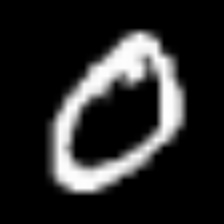

--------------------------------------------------
Key: train_0_1, Label: 0, Shape: (224, 224, 3)


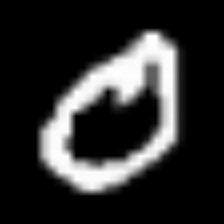

--------------------------------------------------
Key: train_0_2, Label: 0, Shape: (224, 224, 3)


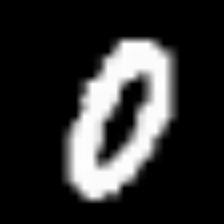

--------------------------------------------------


In [13]:
lmdb_path = './lmdb'
kv_file_path = './lmdb/train_kv.txt'
read_lmdb(lmdb_path, kv_file_path, 3)